# Problem Set 3 - Linear Regression, Logistic Regression, and Feature Engineering
## CSCI 4622 - Spring 2022
***
**Name**: William Yelton
***

This assignment is due on Canvas by **11:59PM on March 14th**.

Submit only this Jupyter notebook to Canvas with the name format `PS3_<yourname>.ipynb`. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question. You can add a write-up markdown cell if it wasn't provided.

Remember that you are encouraged to discuss the problems with your classmates and instructors, 
but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from your own solution to previous homeworks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data
import tests
%matplotlib inline

## Problem 1: Linear Regression (40 points)
For this problem we will be using the same HousePrices data from Problem Set 2, but for our linear regression implementations.

First, we want to scale the prices to the $[0, 1]$ interval using `MinMaxScaler`. Given an array of values $X$, the scaling works as follows:
\begin{align}
    X  \leftarrow \frac{X-min(X)}{max(X) - min(X)}
\end{align}

For a 2-array (where the features are the columns), this is performed as a column-wise operation.

As usual, $min(X)$ and $max(X)$ are computed on the training set.

- 1.1.a **[3 points]** Complete `MinMaxScaler.fit` to compute and save the column-wise min and max.
- 1.1.b **[2 points]** Complete `MinMaxScaler.transform` to apply the min-max scaling using the computed statistics.

In [2]:
class MinMaxScaler:

    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, X):
        """
        Compute and save the features min and max of shape (num_features,)
        (you can also save them with shape (1, num_features))
        :param X: array of shape (num_samples, num_features)
        :return: fitted scaler
        """
        # Workspace 1.1.a
        #BEGIN 
        self.max = max(X)
        self.min = min(X)
        #END
        return self

    def transform(self, X):
        """
        Transform the given samples using the precomputed min and max
        :param X: np.array of shape (num_samples, num_features)
        :return: MinMax scaled X, of shape (num_samples, num_features)
        """
        # Workspace 1.1.b
        #BEGIN 
        newArr = np.zeros(X.shape)
        for sIdx , samp in enumerate(X):
            for fIdx, feat in enumerate(samp): ## for multiple columns case.
                newArr[sIdx,fIdx]= (feat - self.min) / (self.max - self.min)
        return newArr
        #END

    def fit_transform(self, X):
        """
        Fit using X and then transform it. Useful when we need to scale jsut once.
        """
        self.fit(X)
        return self.transform(X)

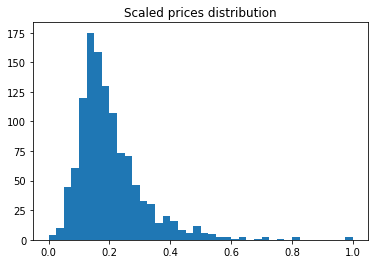

In [3]:
house_prices = data.HousePrices()
minmax_scaler = MinMaxScaler()
# MinMax works on 2-d arrays, so we just need to parse the prices as a single column/feature
# and then squeeze it back to 1-d array
house_prices.y_train = minmax_scaler.fit_transform(house_prices.y_train[:, None])[:, 0]
house_prices.y_test = minmax_scaler.transform(house_prices.y_test[:, None])[:, 0]
plt.hist(house_prices.y_train, bins=40)
plt.title("Scaled prices distribution")
plt.show()

We have seen that Ridge regression adds a regularization term to the least square using the L2 norm.
The objective is then to minimize:

\begin{align}
\frac{1}{N}\sum_{i=1}^{N} ||y_i-{\mathbf w}^T x_i-b||^2 + \alpha||w||^2
\end{align}

where $\mathbf w$ denotes the set of parameters for the linear regression model,
 $\alpha$ is the trade-off regularization parameter, and $N$ the number of samples
The intercept $b$ can also be included in $(x_i)_{i\leq N}$ by appending a constant feature to the data.

To implement Ridge Regression, We'll use the solver from sklearn module `Ridge` ([read more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)).
- 1.2 **[5 points]** Complete the `fit` and `evaluate` methods following the docstring description.

Once you fit the linear model, you have to save the coefficients $\mathbf w$ in `Ridge.coefficients` and the intercept `b` in `Ridge.intercept`.

In [4]:
from sklearn import linear_model


class Ridge:
    def __init__(self, alpha):
        """
        Parameters
        ----------
        alpha:  regularization parameter
        """
        self.alpha = alpha  # regularization / penalty term for weights
        self.coefficients = None  # Coefficients w
        self.intercept = None  # Intercept b
        self._model = linear_model.Ridge(self.alpha, fit_intercept=True)  #using sklearn's implementation of Ridge # Regression

    def fit(self, X, y):
        """
        Fit the ridge model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights.
        :param X: training features (num_samples, n_features)
        :param y: target values (num_samples)
        :return: num_nonzero_coeff : number of non-zero coefficients in the model weights
        """

        #Workspace 1.2.a
        #TODO:  Fit the Ridge model, save the coefficients and intercept and return number of non-zero coefficients
        #BEGIN 
        num_nonzero_coeff = 0
        self._model.fit(X, y)
        self.coefficients = self._model.coef_
        for elm in self.coefficients:
            if elm != 0.0: 
                num_nonzero_coeff += 1
        self.intercept = self._model.intercept_
        #END
        return num_nonzero_coeff

    def evaluate(self, test_x, test_y):
        """
        Compute Root Mean square error (RMSE) between test_y and the prediction from test_x
        :param test_x: shape (num_samples, num_features)
        :param test_y: shape (num_samples,)
        :return: Float
        """
        #Workspace 1.2.b
        mean_squared_error = 0
        #TODO: predict based on the test features and return the mean_squared_error
        #BEGIN
        rmse = 0
        y_hat = self._model.predict(test_x)
        for i in range(len(y_hat)):
            rmse += (y_hat[i] - test_y[i]) ** 2
        rmse = (rmse / len(y_hat)) ** (1/2)
        mean_squared_error = rmse
        #END
        return mean_squared_error

    @staticmethod
    def rmse(y_true, y_hat):
        """
        Compute RMSE between two 1d-arrays
        :param y_true: shape (num_samples,)
        :param y_hat: (num_samples,)
        :return: Float
        """
        rmse = 0
        #Workspace 1.2.c
        #BEGIN 
        for i in range(len(y_true)):
            rmse += (y_hat[i] - y_true[i]) ** 2
        rmse = (rmse / len(y_hat)) ** (1/2)
        #END
        return rmse

In [5]:
# Tests cell
tests.test_ridge_coef(Ridge, normalize=None)
tests.test_ridge_intercept(Ridge, normalize=None)
tests.test_rmse(Ridge.rmse)

Question 1.2.a: [PASS]
Question 1.2.a: [PASS]
Question 1.2.c: [PASS]


1.3 **[5 points]** On the House Prices dataset, produce 2 plots using `Ridge` :
  - The number non-zero coefficients versus $\log_{10}(\alpha)$ (logarithmic scale in x-axis)
  - Root Mean Squared Error (RMSE) on test set versus $\log_{10}(\alpha)$ (logarithmic scale in x-axis)

 Use the values of `alpha` provided below

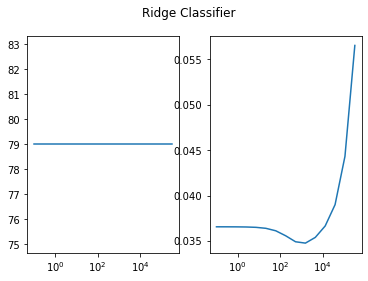

In [6]:
alphas = np.power(10, np.linspace(-1, 5.5, 15))
# Workspace 1.3
#BEGIN
nonZeroLst = np.empty(0)
RMSELst = np.empty(0)
logLst = np.empty(0)
for alpha in alphas:
    rd = Ridge(alpha)
    nz = rd.fit(house_prices.X_train, house_prices.y_train)
    rmse = rd.evaluate(house_prices.X_test, house_prices.y_test)
    nonZeroLst = np.append(nonZeroLst,nz)
    RMSELst = np.append(RMSELst, rmse)
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Ridge Classifier')
# ax1.plot(logLst)
ax1.plot(alphas, nonZeroLst)
ax1.set_xscale('log')
ax2.plot(alphas, RMSELst)
ax2.set_xscale('log')

#END

Now we'll move to Lasso regression. Lasso uses $l_1$ norm in the regularization term and minimizes:
\begin{align}
\frac{1}{2N}\sum_i ||y_i-w^t x_i -b||^2 + \alpha||w||_1
\end{align}

We'll be using the `Lasso`solver from sklearn ([more details](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)).

Complete the Lasso class in the same way as you completed the Ridge class. We'll use the solver from sklearn module `Lasso`
([read more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)).
- 1.4 **[5 points]** Complete the `Lasso` class in a similar way to `Ridge`

Hint: you're allowed to use inheritance

In [7]:
class Lasso:
    def __init__(self, alpha):
        """
        Parameters
        ----------
        alpha:  regularization parameter
        """
        self.alpha = alpha
        self.coefficients = None  # Coefficients w
        self.intercept = None  # Intercept b
        # Workspace 1.4
        # Define self._model using the right linear model
        #BEGIN 
        self._model = linear_model.Lasso(self.alpha, fit_intercept=True)
        #END
    def fit(self, X, y):
        """
        Fit the ridge model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights.
        :param X: training features (num_samples, n_features)
        :param y: target values (num_samples)
        :return: num_nonzero_coeff : number of non-zero coefficients in the model weights
        """

        #Workspace 1.4.a
        # num_nonzero_coeff = 0
        #TODO: Fit the Lasso model, save the coefficients and intercept and return number of non-zero coefficients
        #BEGIN 
        num_nonzero_coeff = 0
        self._model.fit(X, y)
        self.coefficients = self._model.coef_
        for elm in self._model.coef_ :
            if elm != 0: 
                num_nonzero_coeff += 1
        self.intercept = self._model.intercept_
        #END
        return num_nonzero_coeff

    def evaluate(self, test_x, test_y):
        """
        Compute Root Mean square error (RMSE) between test_y and the prediction from test_x
        :param test_x: shape (num_samples, num_features)
        :param test_y: shape (num_samples,)
        :return: Float
        """
        #Workspace 1.4.b
        #TODO: predict based on the test features and return the mean_squared_error        
        #BEGIN 
        rmse = 0
        y_hat = self._model.predict(test_x)
        assert len(y_hat) == len(test_y)
        for i in range(len(y_hat)):
            rmse += (y_hat[i] - test_y[i]) ** 2
        rmse = (rmse / len(y_hat)) ** (1/2)
        mean_squared_error = rmse
        #END
        return mean_squared_error

    @staticmethod
    def rmse(y_true, y_hat):
        """
        Compute RMSE between two 1d-arrays
        :param y_true: shape (num_samples,)
        :param y_hat: (num_samples,)
        :return: Float
        """
        rmse = 0
        #Workspace 1.4.c
        #BEGIN 
        for i in range(len(y_true)):
            rmse += (y_hat[i] - y_true[i]) ** 2
        rmse = (rmse / len(y_hat)) ** (1/2)
        #END
        return rmse

In [8]:
# Tests cell
tests.test_lasso_coef(Lasso, normalize=None)
tests.test_lasso_intercept(Lasso, normalize=None)

Question 1.4.a: [PASS]
Question 1.4.a: [PASS]


- 1.5 **[5 points]** On the House Prices dataset, produce 2 plots using `Lasso` :
  - The number non-zero coefficients versus $\log_{10}(\alpha)$ (logarithmic scale in x-axis)
  - Root Mean Squared Error (RMSE) on test set versus $\log_{10}(\alpha)$ (logarithmic scale in x-axis)

 Use the values of `alpha` provided below

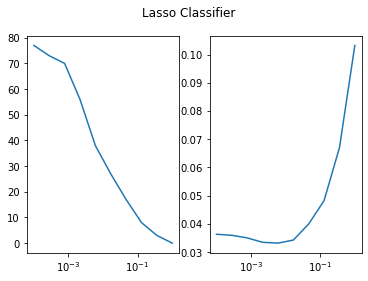

In [9]:
alphas = np.power(10, np.linspace(-4, 0.0, 10))
# Workspace 1.5
#BEGIN 
nonZeroLst = np.empty(0)
RMSELst = np.empty(0)
logLst = np.empty(0)
for alpha in alphas:
    ld = Lasso(alpha)
    nz = ld.fit(house_prices.X_train, house_prices.y_train)
    rmse = ld.evaluate(house_prices.X_test, house_prices.y_test)
    nonZeroLst = np.append(nonZeroLst,nz)
    RMSELst = np.append(RMSELst, rmse)
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Lasso Classifier')
ax1.plot(alphas, nonZeroLst)
ax1.set_xscale('log')
ax2.plot(alphas, RMSELst)
ax2.set_xscale('log')
#END

- 1.6 **[5 points]** Compare the two algorithms on each data set: 
    - Compare the number of non-zero coordinates of Ridge vs Lasso and their RMSE on each dataset.
    - Which type of regression is better for each dataset? 

#### Workspace 1.6
%BEGIN

Ridge and Lasso both started with the around the same number of non-zero coordinates, then Lasso began to lose non-zero coordinates where it didn't change with Ridge. 
Ridge would be better here, RMSE doesn't begin to increase in the same rate until long after Lasso begins to increase.
%END

Elastic Net try to combine both types of regularization to get the best of both worlds by minimizing:

\begin{align}
\frac{1}{2N} \sum_i ||y_i - w^Tx_i -b||^2_2 + \alpha\beta||w||_1 + \frac{\alpha}{2}(1 - \beta)||w||^2_2
\end{align}

where $\beta\in[0,1]$ is the $l_1$ ratio ($\beta=1$ for Lasso and $\beta=0$ for Ridge).

We'll use the solver from sklearn module `ElasticNet`
([read more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)).
`Elastic` class inherits from `Lasso` since their implementation is the same. The only difference is how we define `Elastic._model`

In [10]:
class Elastic(Lasso):
    def __init__(self, alpha, beta=0.5):
        super(Elastic, self).__init__(alpha)
        """
        Parameters
        ----------
        alpha:  First regularization parameter
        beta:   Second regularization parameter (default set to 0.5)        
        """
        self._model = linear_model.ElasticNet(alpha=alpha, l1_ratio=beta, fit_intercept=True)

- 1.7 **[5 points]** For each of the datasets, produce 2 plots using `Elastic` :
  - The number non-zero coefficients versus $\log_{10}(\alpha)$ (logarithmic scale in x-axis)
  - Root Mean Squared Error (RMSE) on test set versus $\log_{10}(\alpha)$ (logarithmic scale in x-axis)

 Use the values of `alpha` provided below

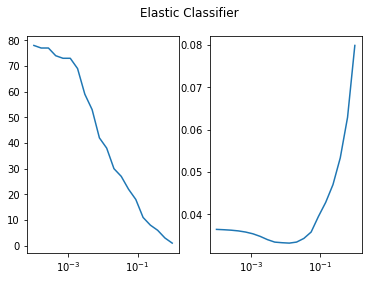

In [11]:
alphas = np.power(10, np.linspace(-4, 0.0, 20))
# Workspace 1.7
#BEGIN 
nonZeroLst = np.empty(0)
RMSELst = np.empty(0)
logLst = np.empty(0)
for alpha in alphas:
    ed = Elastic(alpha)
    nz = ed.fit(house_prices.X_train, house_prices.y_train)
    rmse = ed.evaluate(house_prices.X_test, house_prices.y_test)
    nonZeroLst = np.append(nonZeroLst,nz)
    RMSELst = np.append(RMSELst, rmse)
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Elastic Classifier')
# ax1.plot(logLst)
ax1.plot(alphas, nonZeroLst)
ax1.set_xscale('log')
ax2.plot(alphas, RMSELst)
ax2.set_xscale('log')#END

1.8 **[5 points]** What are the pros and cons of each of three types of regressions we have implemented?

#### Workspace 1.8
%BEGIN

Elastic and Lasso models output looks nearly identical, you can tell the process is slightly different as the graph for Elastic isn't as smooth as Lasso's but they are very similar.  The cons of these methods is that RMSE is minimized when the X value is very low.
<br><br>
On the other hand with the Ridge model RMSE doesn't increase until the X value is a larger positive value.
<br><br>
For the Elastic method the pro is clear, take pros from both Lasso and Ridge.  Cons are more similar to Lasso with LOW X values being where RMSE is lowest. 

%END

***
## Problem 2: Logistic Regression for Binary Classification (38 points)

The second part of this assignment will be dealing with Logistic Regression.
While the name "regression" suggests otherwise, Logistic Regression is actually used for classification.
It's a regression problem because the targets are the continuous likelihoods of the outcomes.

Our dataset is the same one we used in Problem Set 1. Our class label is `0` if the digit is even and 0 otherwise.

In [12]:
binary_digits = data.BinaryDigits()

Using the same notations from Problem 1 (this time with discrete targets $y_i$ in {0, 1}), _Logistic Regression_ is about minimizing the **N**egative **L**og **L**ikelihood objective defined as:
\begin{align}
\textrm{NLL}(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(\mathbf{w}^T{\mathbf{x_i}}) + (1-y_i)\log(1 - \sigma(\mathbf{w}^T\mathbf{x_i}))\right]
\end{align}

You might be wondering: where is the intercept?
We're including the intercept in $(\mathbf x_i)_i$ since we'll be adding a constant feature $\mathbf x_{i,0} = 1$ to all samples $(\mathbf x_i)_i$.
We will call it the zero-th column and the intercept will be $\mathbf{w}_0$.
This zero-th column will be appended to the training samples in `fit` method and the test samples in `predict` method. $\sigma$ is the sigmoid function seen in class.

The gradient of **NLL** w.r.t $\mathbf{w}$ is:

\begin{align}
\frac{\partial \textrm{NLL}}{\partial \mathbf{w}} = \frac{1}{N} \sum_i \left[\sigma(\mathbf{w}^Tx_i)-y_i)\right]x_i
\end{align}

- 2.1 **[4 points]** Complete the `sigmoid` function to return the sigmoid values $\sigma(\mathbf{w}^T{\mathbf{x_i}})$ given features array. You have to truncate the score $\mathbf{w}^T{\mathbf{x_i}}$ to the interval $[-25, 25]$ to avoid overflow of `np.exp`


- 2.2 **[4 points]** Finish the `compute_gradient` function to return the derivative of the cost w.r.t. the weights

- 2.3 **[4 points]** Finish the `batch_update` function so that it performs batch gradient descent using the provided batch data

- 2.4 **[6 points]** Finish the `fit` function so that it performs several training epochs and returns the Recall score on the validation data at the end of each epoch. Initialize $\mathbf{w}$ so that $\mathbf{w}_j = \frac{1}{d}$

- 2.5 **[3 points]** Finish the `predict` method to return the predicted labels (either 0 or 1)


In [13]:
from sklearn.metrics import recall_score

class LogisticRegression:

    def __init__(self, eta=0.1, alpha=0):
        """
        Create a logistic regression classifier
        :param eta: Learning rate

        :param alpha: We will use this parameter later (IN BONUS)
        """

        self.w = None  # uninitialized w
        self.eta = eta  # learning rate
        self.alpha = alpha  # regularization / penalty term (USED IN BONUS)

    def sigmoid(self, x, threshold=25.0):
        """

        :param x: features array of shape (num_samples, num_features + 1) (zero-th column appended)
        :param threshold: the truncating threshold for np.exp, default to 25.0
        :return: sigmoid values , of shape (num_samples,)
        """
        # Workspace 2.1
        # TO DO: Complete this function to return the output of applying the sigmoid function to the score
        #BEGIN 
        clipped = np.clip(np.dot(x, self.w), -threshold, threshold)
        return 1/(1 - np.exp(-clipped)) 
        #END

    def compute_gradient(self, x, y):
        """
        Return the derivative of the cost w.r.t to the weights. Don't forget to average by batch_size
        :param x:  Feature vector, shape (batch_size, num_features +1), with zero-th column appended
        :param y: real binary class label, shape (batch_size)
        :return: gradient of shape (num_features + 1,)
        """

        # Workspace 2.2
        # TO DO: Finish this function to compute the gradient
        gradient = np.zeros((x.shape[1], ))
        #BEGIN 
        batch_size = x.shape[0]
        for i in range(batch_size):
            gradient = gradient + (self.sigmoid(x[i])- y[i]) * x[i]
        gradient = gradient / batch_size
        #END
        return gradient

    def batch_update(self, batch_x, batch_y):
        """
        Single self.w update using the batch.
        :param batch_x: array of features (includes the constant feature at column 0), of shape (batch_size, num_features + 1)
        :param batch_y: array of target values, shape (batch_size,)
        :return: nothing
        """

        # Workspace 2.3
        #BEGIN 
        grad_return = self.compute_gradient(batch_x, batch_y)
        self.w = self.w - self.eta * grad_return
        #END

    def fit(self, X, y, epochs=1, batch_size=1, validation_X=None, validation_y=None):
        """
        train the LogisticRegression
        :param X: training features, shape (num_samples, num_features)
        :param y: training labels, shape (num_samples,)
        :param epochs: number of epochs, integer
        :param batch_size: size of batch for gradient update, 1 for SGD
        :param validation_X: validation rows, should default to training data if not provided
        :param validation_y: validation labels
        :return: recall score at the end of each epoch on validation data
        """

        if validation_X is None:
            validation_X, validation_y = X, y
        self.w = np.ones(X.shape[1] + 1) / (X.shape[1] + 1)
        metrics = []
        # Workspace  2.4
        # TO DO: Process X to append the zero-th constant column and call self.optimize
        # TO DO: Compute average recall on the validation data at the end of each epoch
        # HINT: make sure to initialize w
        #BEGIN 
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)  # We append zero-th column
        ##call predict on validation x 
        for i in range(epochs):
            self.optimize(X,y,batch_size)
            y_hat = self.predict(validation_X)
            metrics.append(recall_score(validation_y, y_hat))
        #END
        return np.array(metrics)

    def predict(self, X):
        """
        :param X: features array, shape (num_samples, num_features) (without the constant column)
        :return: predicted binary label, shape (num_samples,)
        """
        # Workspace 2.5
        y_hat = np.zeros((X.shape[0],))
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)  # We append zero-th column
        #BEGIN 
        result = self.sigmoid(X)
        for i in range(len(result)):
            if result[i] > 0.5:
                y_hat[i] = 1
        #END
        return y_hat

    def optimize(self, X, y, batch_size):
        """
        Perform one epoch batch gradient on shuffled data
        :param X: np.array of shape (num_samples, num_features +1), The training data with zero-th column appended
        :param y: target values of shape (num_samples,)
        :param batch_size: batch_size of the batch_update
        :return: None
        """
        indices = np.random.permutation(len(X))
        for i in range(0, X.shape[0], batch_size):
            batch_x = X[indices[i:i + batch_size]]
            batch_y = y[indices[i:i + batch_size]]
            self.batch_update(batch_x, batch_y)

After completing the class above, loop over the training data and perform batch training with `batch_size=1`(Stochastic Gradient Descent) for 50 epochs, and different values of eta ( see `etas`). Train your model and do the following:

- 2.6 **[5 points]** Plot the recall trend for the different values of eta on the training data (epoch vs recall). (reset random seed for each loop to mitigate the randomness effect)

Use the values provided below

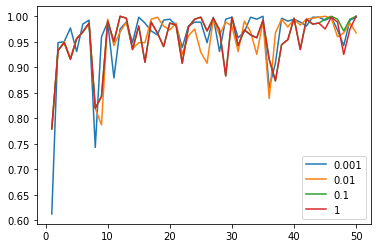

In [14]:
etas = [.001, .01, 0.1, 1]
for eta in etas:
    np.random.seed(42)  # Reset randomness
    # Workspace 2.6
    #BEGIN 
    x = np.linspace(1,50)
    lr = LogisticRegression(eta=eta)
    recall = lr.fit(binary_digits.X_train, binary_digits.y_train, batch_size=1, epochs=50)
#     print(recall)
    plt.plot(x,recall, label = eta)
    #END
plt.legend()
plt.show()

- 2.7 **[3 points]** Plot the recall trend for the different values of eta on the test data.
(reset random seed for each loop to mitigate the randomness effect)

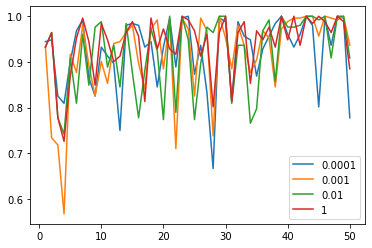

In [15]:
etas = [.0001, .001, .01, 1]

for eta in etas:
    np.random.seed(42)
    # Workspace 2.7
    #BEGIN 
    x = np.linspace(1,50)
    lr = LogisticRegression(eta=eta)
    recall = lr.fit(binary_digits.X_test, binary_digits.y_test, batch_size=1, epochs=50)
#     print(recall)
    plt.plot(x,recall, label = eta)
    #END
plt.legend()
plt.show()

This time we want to analyze the effect of varying the batch size. We fix `eta=0.01` and `epochs=50` and we want to
examine the recall on the test set at the end of the training.

- 2.8 **[5 points]** Produce a plot of the recall on the test data at the end of the training as a function of the batch size. Reset the random generator for each iteration.

Use batch sizes provided below

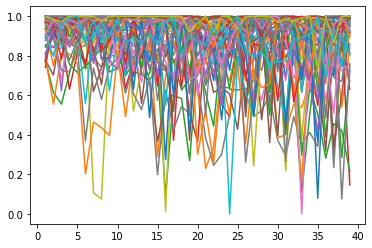

In [16]:
batch_sizes = list(range(1, 40))
recalls = []

for b_size in batch_sizes:
    np.random.seed(42)
    # Workspace 2.8
    #BEGIN 
    lr = LogisticRegression(eta=0.01)
    result = lr.fit(binary_digits.X_test, binary_digits.y_test, batch_size=b_size, epochs=50)
    recalls.append(result)
    #END
plt.plot(batch_sizes, recalls)
plt.show()

2.9 **[4 points]** How does the learning rate (eta) and the number of epochs affect the performance of the classifier.

#### Workspace 2.9

%BEGIN

The number of epochs gives the classifier more time to run, too few epochs and the classifier may never converge on the correct value, where too many would just be doing needless computation after the solution has already been found.

The learning rate being higher makes it so the classifier is updating the parameters more often, A higher learning rate means faster convergence with the possibility of overshooting the optimal solution, where a low learning rate would just require alot more iterations to converge to the same place. 

%END

2.10 (**Bonus**) **[5 points]** Since we're done with the binary regression, we will try to add Ridge regularization:
\begin{align}
\textrm{NLL}(w) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(\mathbf{w}^T{x_i}) + (1-y_i)\log(1 - \sigma(\mathbf{w}^Tx_i))\right] + \alpha {||\mathbf{w}||^2}_{\geq1}
\end{align}

This is exactly what we will be using the `alpha` parameter in `LogisticRegression` for.
First, write the gradient formula in the cell below and edit your `compute_gradient` to account for the regularization term. Note that the regularization $||w||^2$ does not apply to the intercept $\mathbf{w}_0$

#### Workspace 2.10

%BEGIN

% YOUR ANSWER HERE

%END


## Problem 3: Feature Engineering (22 points)
So far in all previous problems, we didn't have to worry about creating the features, that is our `X`. We always relied on having it handed to us.
In practical machine learning problems, however, you will have to do some feature engineering yourself in order to get the features matrix `X` before feeding it to the classifier.

For this problem you will work on extracting features from raw data. You will then use scikit-learn [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) to complete the classification task.

We will start by importing some libraries and loading our data which contains 2,000 reviews from IMDB along with their sentiment, either positive (`1`) or negative (`0`).


In [17]:
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\willy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
imdb = data.IMDB()
print(f"[Example: {imdb.X_train[1][:157]}], label:{imdb.y_train[1]}")

[Example: underrated movies are a common reoccurrence in show business today . 1998's 'hope floats' was extremely underrated and was one of the best movies of the year], label:1


Let's call _Featurizer_ any class that is implemented like `StandardScaler` and our initial `MinMaxScaler`. It has:
- a `fit` method that computes any necessary statistics based on our training data (like mean, min or max)
- a `transform` method that generates new features based on given input and the pre-computed statistics
- a `fit_transform` method that combines the two previous methods

We can also combine multiple _Featurizers_ either in a series using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):
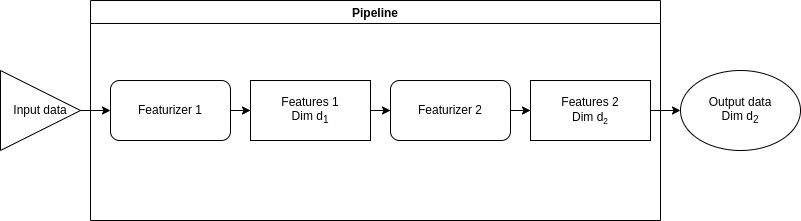

Or in parallel using [`FeatureUnion`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html)
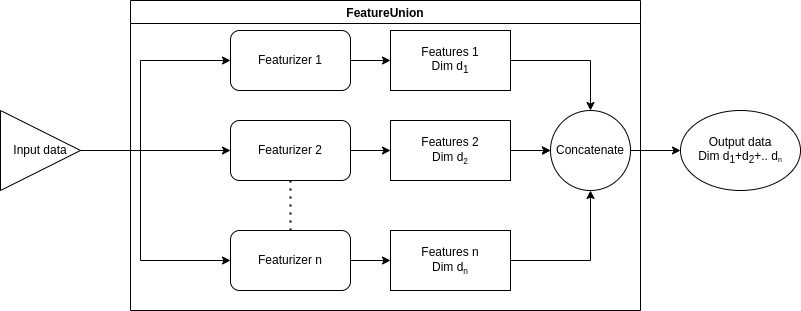

`Pipeline` and `FeatureUnion` are also _Featurizers_.

Both `Pipeline` and `FeatureUnion` take a list of tuples formated as `(features_name: str, featurizer_instance: object)`.

Let's start by extracting some simple features such as the number of sentences in each review.
To do that, we will create a custom scikit-learn feature transformer which will take data as input and returns a feature vector as output.

The feature transformer class has a constructor, a `fit` method. The constructor can be used to store any words or other data that we might need during the feature extraction process.
Feature transformers usually don't need to be fitted, so we will leave that as it is. Most of the work will be done inside the `transform` function.

- 3.1 **[3 points]** Complete the `SentenceCounter` class to extract the number of sentences in each review. 
- 3.2 **[3 points]** Complete the `PunctCounter` class to count the number of "!" and "?" in each review



In [19]:
class SentenceCounter(BaseEstimator, TransformerMixin):
    """
    A custom feature transformer to extract the number of sentences
    """
    def fit(self, data):
        return self

    def transform(self, data):
        """
        :param data: raw data, of length (num_samples,), where each element is a string 
        :return: features array of shape (num_samples, 1)
        """
        features = np.zeros((len(data), 1))
        # Workspace 3.1
        # TODO: Transform reviews into the feature (number of sentences)  
        #BEGIN 
        for idx, sentence in enumerate(data):
            features[idx] = sentence.count(".") ## number of periods == number of sentences ?!; 
            #END
        return features



class PunctCounter(SentenceCounter):
    """
    A custom feature transformer to extract the number of "!" and "?"
    """

    def transform(self, data):
        """
        :param data: raw data, of length (num_samples,), where each element is a string 
        :return: features array of shape (num_samples, 1)
        """
        features = np.zeros((len(data), 1))
        # Workspace 3.2
        # TODO: Transform reviews into the feature (number of "!" and "?")  
        #BEGIN 
        for idx, sentence in enumerate(data):
            ex_count = sentence.count("!") 
            q_count = sentence.count("?")
            features[idx] = ex_count + q_count
        #END
        return features

The `featurizer` instance below combines `FeatureUnion` and `Pipeline` operations. First, we extract the number of punctuations, then normalize the two features.


In [20]:
featurizer = Pipeline([("counts", FeatureUnion([('sentences_count', SentenceCounter()),
                                                ('punct_count', PunctCounter())])),
                       ("normalizer", StandardScaler())])
X_train = featurizer.fit_transform(imdb.X_train)
X_test = featurizer.transform(imdb.X_test)
print(f"means:{np.mean(X_train,axis=0)}, Standard deviations:{np.std(X_train, axis=0)}")
print(X_train.shape, X_test.shape)

means:[-1.17207831e-16  2.52179230e-17], Standard deviations:[1. 1.]
(1400, 2) (600, 2)


Let's see how well this simple feature would help us distinguish positive reviews from negative ones. 

In [21]:
# Train the classifier and find the accuracy on the test dataset
lr = SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
lr.fit(X_train, imdb.y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred, imdb.y_test)
print("Accuracy on testing set: ", accuracy)

Accuracy on testing set:  0.545


Not that helpful!

Well, that was expected! let's create more transformers to extract more valuable features.  

- 3.3 **[4 points]** Complete the `NegativeCounter` feature transformer to extract the number of negative words (vocabulary is provided) 

- 3.4 **[4 points]** Complete the `PositiveCounter` feature transformer to extract the number of positive words (vocabulary is provided)

HINT: Before you match the vocabulary words to the review text, use [`word_tokenize`](https://www.nltk.org/api/nltk.tokenize.html) from `nltk` to convert reviews into tokens. 

In [22]:
class NegativeCounter(SentenceCounter):
    """
    A custom feature transformer to extract the feature "number of negative words" 
    """

    def __init__(self):
        self.neg_words = ["second-rate", "violent", "moronic", "third-rate", "flawed", "juvenile", "boring",
                          "distasteful", "ordinary", "disgusting", "senseless", "static", "brutal", "confused",
                          "disappointing", "bloody", "silly", "tired", "predictable", "stupid", "uninteresting",
                          "weak", "incredibly tiresome", "trite", "uneven", "cliché ridden", "outdated",
                          "dreadful", "bland", "bad", "worst", "waste"]

    def transform(self, data):
        """
        :param data: raw data
        :return: features array of shape (n_samples, 1)
        """
        features = np.zeros((len(data), 1))

        # Workspace 3.3
        # TODO: Transform reviews into the feature (number of negative words)  
        #BEGIN 
        for idx, sent in enumerate(data):
            wrdLst = word_tokenize(sent)
            total = 0 
            for word in wrdLst: 
                if word in self.neg_words: 
                    total += 1
            #END

        return features


class PositiveCounter(NegativeCounter):
    """
    A custom feature transformer to extract the feature "number of positive words"
    """

    def __init__(self):
        self.pos_words = ["first-rate", "insightful", "clever", "charming", "comical", "charismatic", "enjoyable",
                          "uproarious", "original", "tender", "hilarious", "absorbing", "sensitive", "riveting",
                          "intriguing", "powerful", "fascinating", "pleasant", "surprising", "dazzling",
                          "imaginative", "legendary", "unpretentious", "love", "wonderful",
                          "best", "great", "superb", "still", "beautiful"]

    def transform(self, data):
        """
        :param data: raw data
        :return: features array of shape (n_samples, 1)
        """
        features = np.zeros((len(data), 1))
    
        # Workspace 3.4
        # TODO: Transform reviews into the feature (number of positive words)  
        #BEGIN 
        for idx, sent in enumerate(data):
            wrdLst = word_tokenize(sent)
            total = 0 
            for word in wrdLst: 
                if word in self.pos_words: 
                    total += 1 
            features[idx] = total
                #END
        return features

Let's see now how well the classifier would perform with these features that we just engineered. 

- 3.5 **[4 points]** Define `second_featurizer` to combine:`num_of_sentences`, `num_of_negative_words`, `num_of_positive_words`, respectively. 

In [28]:
# Workspace 3.5
#BEGIN 
second_featurizer = Pipeline([("counts", FeatureUnion([('num_of_sentences', SentenceCounter()),
                                                ('num_of_negative_words', NegativeCounter()),
                                                ('num_of_positive_words', PositiveCounter())])),
                       ("normalizer", StandardScaler())])
#END

In [29]:
X_train = second_featurizer.fit_transform(imdb.X_train)
X_test = second_featurizer.transform(imdb.X_test)
print(X_train.shape, X_test.shape)
# Train the classifier and find the accuracy on the test dataset
lr = SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
lr.fit(X_train, imdb.y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred, imdb.y_test)
print("Accuracy on testing set: ", accuracy)

(1400, 3) (600, 3)
Accuracy on testing set:  0.6166666666666667


That's an improvement! Let's try now to include `n-grams` to the list of features.

`N-grams` are all combinations of n-length tokens in a given text. This can be at word level (`word n-grams`) or character level (`char n-grams`) 

For example, if you have the text: `"The movie was great"` , then for this text:

- `unigrams` (`n=1`) at the word level would be `["The", "movie", "was", "great"]` and 
- `bigrams` (`n=2`) at the word level would be `["The movie", "movie was", "was great"]`

and you can generalize this to `n-grams`.

- 3.6 **[4 points]** Define `third_featurizer` to add include an N-hram extractor at the word level.

HINT: use the scikit-learn transformer [`CountVectorizer`](
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [30]:
third_featurizer = FeatureUnion([
    # Workspace 3.6
    # TODO: Add the three feature transformers from 3.5 and a fourth one to extract word n-grams of range  1 to 3
    #BEGIN 
    ('sentences_count', SentenceCounter()),
    ('num_of_negative_words', NegativeCounter()),
    ('num_of_positive_words', PositiveCounter()), 
    ("n_gram_extractor", CountVectorizer())
    #END
])


Let's now see if adding n-grams helped boost the classifier performance. 

In [31]:
X_train = third_featurizer.fit_transform(imdb.X_train)
X_test = third_featurizer.transform(imdb.X_test)
# Train the classifier and find the accuracy on the test dataset
lr = SGDClassifier(loss='log', penalty='l2', alpha=0.0001, max_iter=2000, shuffle=True, verbose=0, random_state=42)
lr.fit(X_train, imdb.y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_pred, imdb.y_test)
print("Accuracy on testing set: ", accuracy)

Accuracy on testing set:  0.825


N-grams definitely helped enhance the classifier performance!

- 4.7 **(Bonus)** Try to a achieve better accuracy on IMDB dataset. You're restricted to using SGDClassifier, but you're free to tweak its parameters. You'll get 1 bonus point for each 1% accuracy above 80% that you achieve (rounded-up)!

In [27]:
# Workspace 4.7
#BEGIN 


#END